# 머신 러닝 교과서 3판

# 15장 - 심층 합성곱 신경망으로 이미지 분류 (1/2)

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part1.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part1.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

- 합성곱 신경망의 구성 요소
    - CNN과 특성 계층 학습
    - 이산 합성곱 수행
        - 1차원 이산 합성곱 수행
        - 출력 특성 맵의 크기를 조절하기 위해 입력에 패딩하기
        - 합성곱 출력 크기 계산
        - 2D 이산 합성곱 수행
    - 서브샘플링
- 기본 구성 요소를 사용하여 심층 합성곱 신경망 구성
    - 여러 개의 입력 또는 컬러 채널 다루기
    - 드롭아웃으로 신경망 규제
    - 분류를 위한 손실 함수
- 텐서플로를 사용하여 심층 합성곱 신경망 구현
    - 다층 CNN 구조
    - 데이터 적재와 전처리
    - 텐서플로 케라스 API를 사용해 CNN 구현하기
        - 케라스에서 CNN 층 설정하기
        - 케라스로 CNN 구성하기

In [1]:
from IPython.display import Image

## 합성곱 신경망의 구성 요소

### CNN과 특성 계층 학습

In [2]:
Image(url='https://git.io/JL5O3', width=700)

### 이산 합성곱 수행

#### 1차원 이산 합성곱 수행

In [3]:
Image(url='https://git.io/JL5On', width=700)

In [4]:
Image(url='https://git.io/JL5O8', width=700)

#### 출력 특성 맵의 크기를 조절하기 위해 입력에 패딩하기

In [5]:
Image(url='https://git.io/JL5Ow', width=700)

#### 합성곱 출력 크기 계산

In [6]:
import tensorflow as tf
import numpy as np

print('텐서플로 버전:', tf.__version__)
print('넘파이 버전: ', np.__version__)

텐서플로 버전: 2.14.0
넘파이 버전:  1.23.5


In [7]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot)) / s) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## 테스트:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d 구현:',
      conv1d(x, w, p=2, s=1))

print('넘파이 결과:',
      np.convolve(x, w, mode='same'))

Conv1d 구현: [ 5. 14. 16. 26. 24. 34. 19. 22.]
넘파이 결과: [ 5 14 16 26 24 34 19 22]


#### 2D 이산 합성곱 수행

In [8]:
Image(url='https://git.io/JL5OP', width=700)

In [9]:
Image(url='https://git.io/JL5OD', width=600)

In [10]:
Image(url='https://git.io/JL5OS', width=800)

In [11]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] -
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] -
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d 구현:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('싸이파이 결과:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d 구현:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
싸이파이 결과:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


### 서브샘플링

In [12]:
Image(url='https://git.io/JL5OH', width=700)

## 기본 구성 요소를 사용하여 심층 합성곱 신경망 구성

### 여러 개의 입력 또는 컬러 채널 다루기

In [13]:
Image(url='https://git.io/JL5O5', width=800)

**팁: 이미지 파일 읽기**

In [14]:
# 코랩에서 실행할 경우 이미지를 먼저 다운로드합니다
!wget https://git.io/JL5Ob -O example-image.png

--2023-11-10 05:55:47--  https://git.io/JL5Ob
Resolving git.io (git.io)... 140.82.112.21
Connecting to git.io (git.io)|140.82.112.21|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch15/example-image.png [following]
--2023-11-10 05:55:48--  https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch15/example-image.png
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch15/example-image.png [following]
--2023-11-10 05:55:48--  https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch15/example-image.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.1

In [15]:
import tensorflow as tf


img_raw = tf.io.read_file('example-image.png')
img = tf.image.decode_image(img_raw)
print('이미지 크기:', img.shape)
print('채널 개수:', img.shape[2])
print('이미지 데이터 타입:', img.dtype)
print(img[100:102, 100:102, :])

이미지 크기: (252, 221, 3)
채널 개수: 3
이미지 데이터 타입: <dtype: 'uint8'>
tf.Tensor(
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]], shape=(2, 2, 3), dtype=uint8)


In [16]:
import imageio


img = imageio.imread('example-image.png')
print('이미지 크기:', img.shape)
print('채널 개수:', img.shape[2])
print('이미지 데이터 타입:', img.dtype)
print(img[100:102, 100:102, :])

이미지 크기: (252, 221, 3)
채널 개수: 3
이미지 데이터 타입: uint8
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]]


<ipython-input-16-a4e5e9d88497>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('example-image.png')


**노트: CNN 입력을 위한 흑백 이미지의 랭크**

In [17]:
# 코랩에서 실행할 경우 이미지를 먼저 다운로드합니다
!wget https://git.io/JL5Op -O example-image-gray.png

--2023-11-10 05:55:52--  https://git.io/JL5Op
Resolving git.io (git.io)... 140.82.112.21
Connecting to git.io (git.io)|140.82.112.21|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch15/example-image-gray.png [following]
--2023-11-10 05:55:52--  https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch15/example-image-gray.png
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch15/example-image-gray.png [following]
--2023-11-10 05:55:52--  https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch15/example-image-gray.png
Resolving raw.githubusercontent.com (raw.githubusercontent.c

In [18]:
img_raw = tf.io.read_file('example-image-gray.png')
img = tf.image.decode_image(img_raw)
tf.print('랭크:', tf.rank(img))
tf.print('크기:', img.shape)

랭크: 3
크기: TensorShape([252, 221, 1])


In [19]:
img = imageio.imread('example-image-gray.png')
tf.print('랭크:', tf.rank(img))
tf.print('크기:', img.shape)

img_reshaped = tf.reshape(img, (img.shape[0], img.shape[1], 1))
tf.print('새로운 크기:', img_reshaped.shape)

랭크: 2
크기: (252, 221)
새로운 크기: TensorShape([252, 221, 1])


<ipython-input-19-1945a6479fb6>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('example-image-gray.png')


### 드롭아웃으로 신경망 규제

In [20]:
Image(url='https://git.io/JL5Oh', width=700)

In [21]:
from tensorflow import keras


conv_layer = keras.layers.Conv2D(
    filters=16, kernel_size=(3, 3),
    kernel_regularizer=keras.regularizers.l2(0.001))

fc_layer = keras.layers.Dense(
    units=16, kernel_regularizer=keras.regularizers.l2(0.001))

### 분류를 위한 손실 함수

 * **`BinaryCrossentropy()`**
   * `from_logits=False`
   * `from_logits=True`

 * **`CategoricalCrossentropy()`**
   * `from_logits=False`
   * `from_logits=True`
   
 * **`SparseCategoricalCrossentropy()`**
   * `from_logits=False`
   * `from_logits=True`

In [22]:
Image(url='https://git.io/JL53f', width=800)

In [23]:
from packaging.version import Version


####### 이진 크로스 엔트로피
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)

tf.print(
    'BCE (확률): {:.4f}'.format(
    bce_probas(y_true=[1], y_pred=probas)),
    '(로짓): {:.4f}'.format(
    bce_logits(y_true=[1], y_pred=logits)))


####### 범주형 크로스 엔트로피
cce_probas = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True)

logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)

if Version(tf.__version__) >= Version('2.3.0'):
    tf.print(
        'CCE (확률): {:.4f}'.format(
        cce_probas(y_true=[[0, 0, 1]], y_pred=probas)),
        '(로짓): {:.4f}'.format(
        cce_logits(y_true=[[0, 0, 1]], y_pred=logits)))
else:
    tf.print(
        'CCE (확률): {:.4f}'.format(
        cce_probas(y_true=[0, 0, 1], y_pred=probas)),
        '(로짓): {:.4f}'.format(
        cce_logits(y_true=[0, 0, 1], y_pred=logits)))

####### 희소 범주형 크로스 엔트로피
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)

tf.print(
    'Sparse CCE (확률): {:.4f}'.format(
    sp_cce_probas(y_true=[2], y_pred=probas)),
    '(로짓): {:.4f}'.format(
    sp_cce_logits(y_true=[2], y_pred=logits)))

BCE (확률): 0.3711 (로짓): 0.3711
CCE (확률): 0.5996 (로짓): 0.5996
Sparse CCE (확률): 0.5996 (로짓): 0.5996


<ipython-input-23-46de39851a3f>:27: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if Version(tf.__version__) >= '2.3.0':


## 텐서플로를 사용하여 심층 합성곱 신경망 구현

### 다층 CNN 구조

In [24]:
Image(url='https://git.io/JL53U', width=800)

### 데이터 적재와 전처리

In [25]:
import tensorflow_datasets as tfds
import pandas as pd

import matplotlib.pyplot as plt

In [26]:
## MNIST 데이터셋

mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
print(datasets.keys())
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
dict_keys(['test', 'train'])


In [27]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [28]:
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

### 텐서플로 케라스 API를 사용해 CNN 구현하기

#### 케라스에서 CNN 층 설정하기

 * **Conv2D:** `tf.keras.layers.Conv2D`
   * `filters`
   * `kernel_size`
   * `strides`
   * `padding`
   
   
 * **MaxPool2D:** `tf.keras.layers.MaxPool2D`
   * `pool_size`
   * `strides`
   * `padding`
   
   
 * **Dropout** `tf.keras.layers.Dropout2D`
   * `rate`

#### 케라스로 CNN 구성하기

In [29]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))

model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

In [30]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

In [31]:
model.add(tf.keras.layers.Flatten())

model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

In [32]:
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1',
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))

model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

In [33]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))

model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 10])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 14, 14, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              3212288   
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

history = model.fit(mnist_train, epochs=NUM_EPOCHS,
                    validation_data=mnist_valid,
                    shuffle=True)

Epoch 1/20
782/782 [==============================] - 23s 10ms/step - loss: 0.1423 - accuracy: 0.9558 - val_loss: 0.0472 - val_accuracy: 0.9860
Epoch 2/20
782/782 [==============================] - 6s 7ms/step - loss: 0.0449 - accuracy: 0.9856 - val_loss: 0.0396 - val_accuracy: 0.9885
Epoch 3/20
782/782 [==============================] - 7s 8ms/step - loss: 0.0302 - accuracy: 0.9906 - val_loss: 0.0399 - val_accuracy: 0.9886
Epoch 4/20
782/782 [==============================] - 8s 9ms/step - loss: 0.0225 - accuracy: 0.9930 - val_loss: 0.0375 - val_accuracy: 0.9893
Epoch 5/20
782/782 [==============================] - 7s 7ms/step - loss: 0.0175 - accuracy: 0.9943 - val_loss: 0.0361 - val_accuracy: 0.9910
Epoch 6/20
782/782 [==============================] - 7s 8ms/step - loss: 0.0141 - accuracy: 0.9953 - val_loss: 0.0374 - val_accuracy: 0.9897
Epoch 7/20
782/782 [==============================] - 8s 9ms/step - loss: 0.0131 - accuracy: 0.9956 - val_loss: 0.0377 - val_accuracy: 0.9898
Epoc

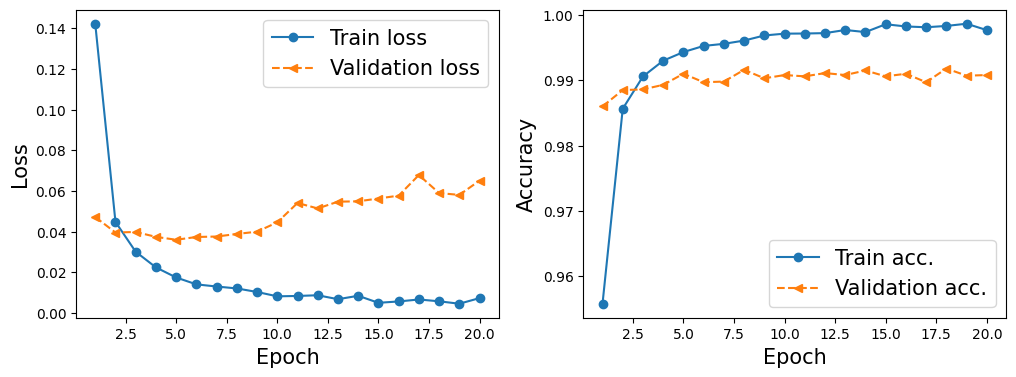

In [36]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('images/15_12.png', dpi=300)
plt.show()

In [37]:
test_results = model.evaluate(mnist_test.batch(20))
print('\n테스트 정확도 {:.2f}%'.format(test_results[1]*100))

500/500 [==============================] - 2s 4ms/step - loss: 0.0503 - accuracy: 0.9919

테스트 정확도 99.19%


TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


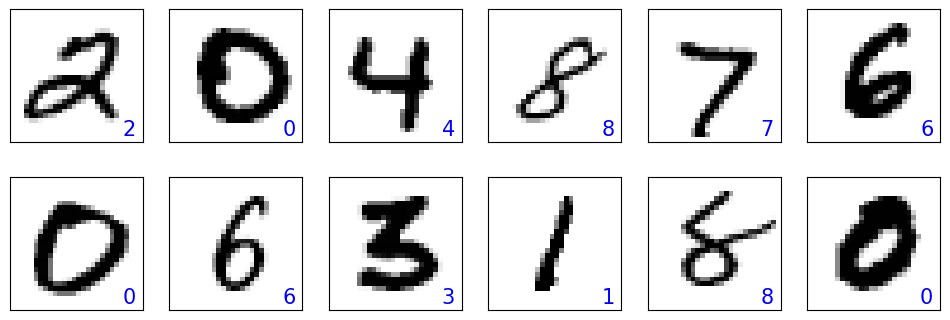

In [38]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

#plt.savefig('images/15_13.png', dpi=300)
plt.show()

In [39]:
import os

if not os.path.exists('models'):
    os.mkdir('models')


model.save('models/mnist-cnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
